In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm._tqdm_notebook import tqdm_notebook
from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  # Remove the CWD from sys.path while we load stuff.


In [2]:
# Считываем данные
tr_mcc_codes = pd.read_csv('data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('data/transactions.csv', index_col='customer_id')
gender_train = pd.read_csv('data/gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('data/gender_test_kaggle_sample_submission.csv', index_col='customer_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

del transactions

In [3]:
transactions_train

,tr_datetime,mcc_code,tr_type,amount,term_id,gender
customer_id,,,,,,
22899,1 15:26:45,4814,1030,-4491.83,NaN,1
22899,2 20:52:48,4814,1030,-2245.92,NaN,1
22899,5 18:52:19,6011,2010,-44918.32,NaN,1
22899,6 12:28:22,6011,2010,-150476.36,NaN,1
22899,28 10:41:01,6010,7030,33688.74,NaN,1
...,...,...,...,...,...,...
99999680,444 00:00:00,5411,1110,-5659.71,31190432,1
99999680,444 00:00:00,6011,2110,-134754.95,406826,1
99999680,446 00:00:00,5541,1110,-11229.58,J038003,1


In [5]:
transactions_train.amount.describe()

count    3.751083e+06
mean    -2.138264e+04
std      5.438054e+05
min     -1.459845e+08
25%     -2.245916e+04
50%     -5.614790e+03
75%     -1.122960e+03
max      1.459845e+08
Name: amount, dtype: float64

In [6]:
tr_mcc_codes

,mcc_description
mcc_code,
742,Ветеринарные услуги
1711,"Генеральные подрядчики по вентиляции, теплосна..."
1731,Подрядчики по электричеству
1799,"Подрядчики, специализированная торговля — нигд..."
2741,Разнообразные издательства/печатное дело
...,...
9211,"Судовые выплаты, включая алименты и детскую по..."
9222,Штрафы
9311,Налоговые платежи


In [7]:
tr_types

,tr_description
tr_type,
3200,Плата за предоставление услуг посредством моби...
3210,Плата за предоставление отчета по счету карты ...
3800,Плата за обслуживание банковской карты (за пер...
4000,Плата за получение наличных в Сбербанке
4001,Плата за получение наличных в Сбербанке (в дру...
...,...
2990,Списание по требованию
2992,Списание средств для погашения задолженности п...
3001,Комиссия за обслуживание ссудного счета


In [8]:
df_train = transactions_train.join(tr_types, on='tr_type').join(tr_mcc_codes, on='mcc_code')
df_train

,tr_datetime,mcc_code,tr_type,amount,term_id,gender,tr_description,mcc_description
customer_id,,,,,,,,
22899,1 15:26:45,4814,1030,-4491.83,NaN,1,Оплата услуги. Банкоматы СБ РФ,"Звонки с использованием телефонов, считывающих..."
22899,2 20:52:48,4814,1030,-2245.92,NaN,1,Оплата услуги. Банкоматы СБ РФ,"Звонки с использованием телефонов, считывающих..."
22899,5 18:52:19,6011,2010,-44918.32,NaN,1,Выдача наличных в АТМ Сбербанк России,Финансовые институты — снятие наличности автом...
22899,6 12:28:22,6011,2010,-150476.36,NaN,1,Выдача наличных в АТМ Сбербанк России,Финансовые институты — снятие наличности автом...
22899,28 10:41:01,6010,7030,33688.74,NaN,1,Перевод на карту (с карты) через АТМ (в предел...,Финансовые институты — снятие наличности вручную
...,...,...,...,...,...,...,...,...
99999680,444 00:00:00,5411,1110,-5659.71,31190432,1,Покупка. POS ТУ Россия,"Бакалейные магазины, супермаркеты"
99999680,444 00:00:00,6011,2110,-134754.95,406826,1,Наличные. АТМ Россия,Финансовые институты — снятие наличности автом...
99999680,446 00:00:00,5541,1110,-11229.58,J038003,1,Покупка. POS ТУ Россия,Станции техобслуживания


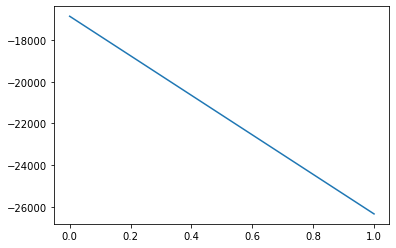

In [9]:
plt.plot(transactions_train.groupby('gender').amount.mean())

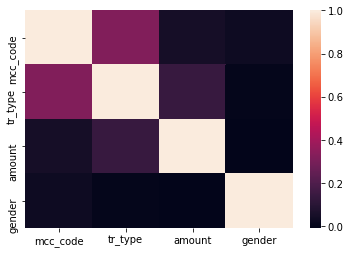

In [10]:
sns.heatmap(transactions_train.corr())

In [11]:
mccs = transactions_train.mcc_code.unique()
tr_types = transactions_train.tr_type.unique()
def make_data(df):
    df = df.copy()
    print(df)
    df = df.drop(['term_id'], axis=1)
    customers = df.groupby('customer_id')

    df['hour'] = df.tr_datetime.apply(lambda x: int(x.split(' ')[1].split(':')[0]))
    df['min'] = df.tr_datetime.apply(lambda x: int(x.split(' ')[1].split(':')[1]))

    amount_mean = customers.amount.mean()
    amount_std = customers.amount.std()
    amount_25 = customers.amount.quantile(.25)
    amount_50 = customers.amount.quantile(.50)
    amount_75 = customers.amount.quantile(.75)
    amount_min = customers.amount.min()
    amount_max = customers.amount.max()

    d = [{"{}_mean".format(i): customers["{}".format(i)].mean(),
     "{}_min".format(i): customers["{}".format(i)].min(),
     "{}_max".format(i): customers["{}".format(i)].max(),
     "{}_25".format(i): customers["{}".format(i)].quantile(.25),
     "{}_50".format(i): customers["{}".format(i)].quantile(.5),
     "{}_75".format(i): customers["{}".format(i)].quantile(.75),
     "{}_std".format(i): customers["{}".format(i)].std()}
      for i in ['amount', 'hour']]

    d[0].update(d[1])
    if 'gender' in df.columns:
        gender = customers.gender.max()
        d[0].update({"gender": gender})
        
    stats_df = pd.DataFrame(d[0])
    
    
    d = {}
    for cust_id in df.index.unique():
        d[cust_id] = {"mccs": np.array(mccs), "tr_types": np.array(tr_types)}
        data = df[df.index == cust_id]
        m = data.mcc_code.values
        for i, mcc in enumerate(mccs):
            d[cust_id]['mccs'][i] = (m == mcc).sum()
        m = data.tr_type.values
        for i, tr_type in enumerate(tr_types):
            d[cust_id]['tr_types'][i] = (m == mcc).sum()
            
            
    df = pd.DataFrame([(e, *d[e]['mccs'], *d[e]['tr_types']) for e in d])
    df.index = df[0]
    df = df.iloc[:, 1:]
    
    
    return stats_df.join(df)



In [12]:
df = make_data(transactions_train)

              tr_datetime  mcc_code  tr_type     amount   term_id  gender
customer_id                                                              
22899          1 15:26:45      4814     1030   -4491.83       NaN       1
22899          2 20:52:48      4814     1030   -2245.92       NaN       1
22899          5 18:52:19      6011     2010  -44918.32       NaN       1
22899          6 12:28:22      6011     2010 -150476.36       NaN       1
22899         28 10:41:01      6010     7030   33688.74       NaN       1
...                   ...       ...      ...        ...       ...     ...
99999680     444 00:00:00      5411     1110   -5659.71  31190432       1
99999680     444 00:00:00      6011     2110 -134754.95    406826       1
99999680     446 00:00:00      5541     1110  -11229.58   J038003       1
99999680     451 09:56:17      6010     7070    1122.96    945022       1
99999680     456 06:28:00      4814     1030   -6737.75    171703       1

[3751083 rows x 6 columns]


In [13]:
df

,amount_mean,amount_min,amount_max,amount_25,amount_50,amount_75,amount_std,hour_mean,hour_min,hour_max,...,251,252,253,254,255,256,257,258,259,260
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,-2691.438419,-868607.92,875907.15,-13475.4900,-3368.870,5249.8275,127851.642622,12.837607,0,22,...,0,0,0,0,0,0,0,0,0,0
28753,-90293.479116,-3244539.76,3099363.77,-133519.6925,-14969.030,-3761.9075,785586.199773,6.503401,0,21,...,0,0,0,0,0,0,0,0,0,0
42096,-5907.505855,-337785.73,673774.73,-19286.2975,-7936.840,-2683.8700,63639.188660,10.274573,0,23,...,0,0,0,0,0,0,0,0,0,0
49793,-47815.367700,-673774.73,112295.79,-6524.3900,-3450.180,-2083.3100,161784.403694,12.873294,0,23,...,0,0,0,0,0,0,0,0,0,0
50940,-14489.383559,-110049.87,4491.83,-17967.3300,-8983.660,-2245.9200,18341.188346,15.635593,5,23,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99917144,-13950.857149,-527790.21,22459.16,-5019.4000,-2157.205,-1027.2275,52253.130339,15.565672,0,23,...,0,0,0,0,0,0,0,0,0,0
99967537,-142010.982308,-336887.37,-2245.92,-269509.8900,-145984.530,-4491.8300,137243.506029,11.923077,9,16,...,0,0,0,0,0,0,0,0,0,0
99984336,-130100.870635,-606397.26,804037.85,-275124.6800,-112295.790,44918.3200,231902.838671,9.857143,0,17,...,0,0,0,0,0,0,0,0,0,0


In [15]:
X = df.drop(['gender'], axis=1).values
y = df.gender.values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [17]:
reg = xgb.XGBRegressor()

In [18]:
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [19]:
y_pred = reg.predict(X_test)

In [20]:
roc_auc_score(y_test, y_pred)

0.8251642731840753

In [21]:
reg.fit(X, y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [22]:
df = make_data(transactions_test)

              tr_datetime  mcc_code  tr_type      amount term_id  probability
customer_id                                                                  
6815          10 10:52:00      4814     1030    -2245.92     NaN     0.420958
6815          10 14:44:36      4814     1030    -2245.92     NaN     0.420958
6815          11 10:23:14      6010     7031  2470507.35     NaN     0.420958
6815          14 12:49:46      6011     2010   -11229.58     NaN     0.420958
6815          17 12:33:31      4814     1030    -2245.92     NaN     0.420958
...                   ...       ...      ...         ...     ...          ...
99991245     437 09:55:16      6011     2010    -4491.83  700072     0.759892
99991245     438 06:27:05      6011     2010  -134754.95  700072     0.759892
99991245     439 06:32:28      6010     7030   168443.68  705844     0.759892
99991245     439 06:32:56      4829     2330  -168443.68  705844     0.759892
99991245     444 06:43:07      6011     7010    60639.73  705843

In [23]:
X_test = df.values

In [24]:
X_test.shape

(3600, 274)

In [25]:
pred = reg.predict(X_test)

In [27]:
gender_test

,probability
customer_id,
75562265,0.120880
84816985,0.395294
54129921,-0.072043
23160845,-0.066889
45646491,0.648952
...,...
89647691,0.185848
53818229,0.134597
88924303,0.358475


In [26]:
gender_test.probability = pred

In [28]:
gender_test.index = df.index

In [29]:
gender_test.to_csv('ans.csv')